In [1]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

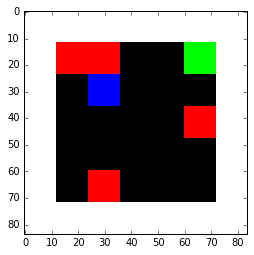

In [2]:
from gridworld_v02 import gameEnv
env = gameEnv(partial=False, size=5)

In [3]:
class Qnetwork():
    def __init__(self, h_size): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutinoal layers.
        self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        self.conv1 = slim.conv2d(inputs=self.imageIn,
                                 num_outputs=32,
                                 kernel_size=[8,8],
                                 stride=[4,4],
                                 padding='VALID', 
                                 biases_initializer = None)
        
        self.conv2 = slim.conv2d(inputs=self.conv1,
                                 num_outputs=64,
                                 kernel_size=[4,4],
                                 stride=[2,2],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv3 = slim.conv2d(inputs=self.conv2,
                                 num_outputs=64,
                                 kernel_size=[3,3],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv4 = slim.conv2d(inputs=self.conv3,
                                 num_outputs=h_size,
                                 kernel_size=[7,7],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        #We take the output from the final convolutional layer and split it into separated terms: advantage & value
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        self.AW = tf.Variable(xavier_init([h_size//2, env.actions]))
        self.VM = tf.Variable(xavier_init([h_size//2, 1]))
        
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VM)
        
        #Then combine to obtain the final Q-value //why substract mean from Advantage?
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)    
    

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [5]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [6]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [7]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 4 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 

num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
pre_train_steps = 10000 #Number of random action steps before training begins

max_epLength = 50 #Maximun allowed length of a game episode

load_model = False #Wheter to load a saved model
path = "./dqn_logs3" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [8]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [9]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
#f.write(final_log)
#f.close()

Saved Model
127 -1.0 1
175 -1.0 1
271 -0.8 1
392 -1.0 1
467 -0.6 1
560 -0.6 1
666 -0.2 1
721 -0.4 1
831 -0.6 1
884 -0.6 1
929 -0.8 1
1025 -0.6 1
1104 -1.0 1
1176 -0.4 1
1269 0.0 1
1355 -0.8 1
1456 -1.0 1
1508 -0.6 1
1650 0.0 1
1766 -0.7 1
1830 -0.8 1
1962 -0.6 1
2078 -0.6 1
2162 -0.6 1
2238 -1.0 1
2360 -1.0 1
2432 -0.6 1
2493 -0.6 1
2596 -0.4 1
2737 -0.6 1
2799 -0.4 1
2863 -0.2 1
2968 -0.4 1
3043 -0.6 1
3098 -0.6 1
3199 -0.3 1
3321 -0.6 1
3435 -0.5 1
3580 -1.0 1
3658 -0.2 1
3731 -0.4 1
3875 -0.2 1
3934 -1.0 1
4023 -0.6 1
4121 -0.8 1
4193 -1.0 1
4275 -0.8 1
4431 -0.4 1
4521 -0.8 1
4639 -0.5 1
4717 -1.0 1
4809 -1.0 1
4881 0.0 1
5024 -0.6 1
5119 0.0 1
5186 -0.8 1
5294 -0.4 1
5374 -0.8 1
5447 -0.6 1
5535 0.0 1
5593 0.0 1
5654 -1.0 1
5762 0.2 1
5865 -0.2 1
5979 -0.6 1
6064 -0.4 1
6163 -0.4 1
6269 -0.1 1
6394 -0.2 1
6497 -0.8 1
6611 -0.4 1
6692 -0.6 1
6741 -0.8 1
6831 -0.2 1
6877 -1.0 1
6940 0.0 1
7047 -0.6 1
7119 -0.4 1
7222 -0.6 1
7296 -0.4 1
7357 -0.6 1
7460 -1.0 1
7510 -0.8 1
7629 -0.8 1

77668 0.1 0.09999999999985551
78071 -0.1 0.09999999999985551
78409 -0.5 0.09999999999985551
78708 -0.4 0.09999999999985551
79059 0.0 0.09999999999985551
79376 -0.2 0.09999999999985551
79791 -0.3 0.09999999999985551
80199 -0.2 0.09999999999985551
80564 -0.2 0.09999999999985551
80972 -0.2 0.09999999999985551
81306 -0.2 0.09999999999985551
81679 -0.4 0.09999999999985551
82042 -0.2 0.09999999999985551
82333 -0.1 0.09999999999985551
82832 -0.1 0.09999999999985551
83294 -0.1 0.09999999999985551
83702 0.0 0.09999999999985551
84108 -0.3 0.09999999999985551
84521 -0.4 0.09999999999985551
84932 -0.1 0.09999999999985551
85233 -0.5 0.09999999999985551
85611 -0.4 0.09999999999985551
85989 -0.2 0.09999999999985551
86385 0.1 0.09999999999985551
86740 -0.2 0.09999999999985551
87107 -0.4 0.09999999999985551
87481 -0.1 0.09999999999985551
87810 -0.5 0.09999999999985551
88240 -0.2 0.09999999999985551
88636 -0.3 0.09999999999985551
89046 -0.4 0.09999999999985551
89386 -0.1 0.09999999999985551
89710 -0.3 0

176012 -0.1 0.09999999999985551
176439 -0.2 0.09999999999985551
176837 -0.4 0.09999999999985551
177165 -0.4 0.09999999999985551
177572 -0.3 0.09999999999985551
177954 -0.5 0.09999999999985551
Saved Model
178240 -0.5 0.09999999999985551
178667 0.0 0.09999999999985551
179052 -0.3 0.09999999999985551
179418 0.1 0.09999999999985551
179763 0.0 0.09999999999985551
180202 -0.2 0.09999999999985551
180596 0.0 0.09999999999985551
180942 -0.3 0.09999999999985551
181385 -0.3 0.09999999999985551
181678 -0.2 0.09999999999985551
182178 0.0 0.09999999999985551
182514 -0.2 0.09999999999985551
182857 -0.5 0.09999999999985551
183285 -0.4 0.09999999999985551
183660 0.0 0.09999999999985551
184052 -0.3 0.09999999999985551
184431 -0.4 0.09999999999985551
184773 -0.2 0.09999999999985551
185183 -0.2 0.09999999999985551
185555 -0.4 0.09999999999985551
186023 0.0 0.09999999999985551
186487 -0.1 0.09999999999985551
186868 -0.5 0.09999999999985551
187266 -0.4 0.09999999999985551
187648 -0.3 0.09999999999985551
188

274061 0.1 0.09999999999985551
274352 -0.1 0.09999999999985551
274809 -0.2 0.09999999999985551
275218 -0.1 0.09999999999985551
275608 -0.2 0.09999999999985551
276061 0.2 0.09999999999985551
276516 -0.1 0.09999999999985551
276986 -0.1 0.09999999999985551
277435 -0.3 0.09999999999985551
277787 -0.5 0.09999999999985551
278138 -0.2 0.09999999999985551
278470 -0.4 0.09999999999985551
278833 -0.1 0.09999999999985551
279264 -0.1 0.09999999999985551
279613 -0.4 0.09999999999985551
280017 0.0 0.09999999999985551
280402 -0.1 0.09999999999985551
280895 -0.1 0.09999999999985551
281286 -0.5 0.09999999999985551
281779 -0.1 0.09999999999985551
282039 -0.2 0.09999999999985551
282382 -0.3 0.09999999999985551
282808 -0.1 0.09999999999985551
283112 -0.3 0.09999999999985551
283605 -0.2 0.09999999999985551
283917 -0.1 0.09999999999985551
284285 0.0 0.09999999999985551
284541 0.1 0.09999999999985551
284867 -0.4 0.09999999999985551
285188 -0.5 0.09999999999985551
285628 -0.2 0.09999999999985551
286086 -0.1 0

362272 -0.4 0.09999999999985551
362644 -0.1 0.09999999999985551
363044 0.0 0.09999999999985551
363340 -0.2 0.09999999999985551
363672 0.1 0.09999999999985551
364026 -0.2 0.09999999999985551
364400 -0.2 0.09999999999985551
364678 0.4 0.09999999999985551
365027 -0.4 0.09999999999985551
365274 -0.4 0.09999999999985551
365434 -0.2 0.09999999999985551
365670 -0.1 0.09999999999985551
365992 -0.4 0.09999999999985551
366326 -0.1 0.09999999999985551
366510 0.3 0.09999999999985551
366784 -0.1 0.09999999999985551
367086 0.2 0.09999999999985551
367327 -0.3 0.09999999999985551
367617 -0.3 0.09999999999985551
367899 -0.1 0.09999999999985551
368102 -0.1 0.09999999999985551
368342 0.1 0.09999999999985551
368675 -0.1 0.09999999999985551
368875 -0.2 0.09999999999985551
369140 0.0 0.09999999999985551
369494 0.2 0.09999999999985551
369804 -0.1 0.09999999999985551
370052 -0.3 0.09999999999985551
370395 0.4 0.09999999999985551
370727 -0.3 0.09999999999985551
371038 -0.2 0.09999999999985551
371309 -0.2 0.099

422219 0.6 0.09999999999985551
422296 0.6 0.09999999999985551
422440 0.6 0.09999999999985551
422585 0.5 0.09999999999985551
422742 0.8 0.09999999999985551
422815 0.7 0.09999999999985551
422939 0.4 0.09999999999985551
423070 0.7 0.09999999999985551
423118 0.4 0.09999999999985551
423162 0.4 0.09999999999985551
423254 0.8 0.09999999999985551
423408 0.6 0.09999999999985551
423516 0.4 0.09999999999985551
423753 -0.2 0.09999999999985551
423886 0.1 0.09999999999985551
424056 0.4 0.09999999999985551
424149 0.9 0.09999999999985551
424339 0.5 0.09999999999985551
424459 0.8 0.09999999999985551
424502 0.6 0.09999999999985551
424578 0.7 0.09999999999985551
424680 0.6 0.09999999999985551
424881 0.7 0.09999999999985551
425009 0.3 0.09999999999985551
425131 0.1 0.09999999999985551
425297 0.3 0.09999999999985551
425396 0.5 0.09999999999985551
425558 0.4 0.09999999999985551
425709 -0.3 0.09999999999985551
Saved Model
425861 0.0 0.09999999999985551
426082 0.2 0.09999999999985551
426279 0.5 0.099999999999

451579 0.4 0.09999999999985551
451700 0.8 0.09999999999985551
451781 0.4 0.09999999999985551
451866 1.0 0.09999999999985551
452017 0.5 0.09999999999985551
452114 0.4 0.09999999999985551
452168 0.8 0.09999999999985551
452264 0.7 0.09999999999985551
452414 0.6 0.09999999999985551
452506 0.5 0.09999999999985551
452567 0.8 0.09999999999985551
452611 1.0 0.09999999999985551
452647 0.8 0.09999999999985551
452753 0.3 0.09999999999985551
452894 0.5 0.09999999999985551
453065 0.6 0.09999999999985551
453144 0.8 0.09999999999985551
453261 0.7 0.09999999999985551
453379 1.0 0.09999999999985551
453473 0.7 0.09999999999985551
453645 0.3 0.09999999999985551
453732 0.8 0.09999999999985551
453842 0.5 0.09999999999985551
453958 0.5 0.09999999999985551
453987 0.8 0.09999999999985551
454141 0.8 0.09999999999985551
454298 0.8 0.09999999999985551
454387 0.3 0.09999999999985551
454425 0.8 0.09999999999985551
454538 0.5 0.09999999999985551
454631 0.6 0.09999999999985551
454724 0.7 0.09999999999985551
454861 0

478706 0.8 0.09999999999985551
Saved Model
478755 0.8 0.09999999999985551
478828 1.0 0.09999999999985551
478890 0.8 0.09999999999985551
479016 0.3 0.09999999999985551
479108 0.4 0.09999999999985551
479262 0.3 0.09999999999985551
479364 0.7 0.09999999999985551
479435 0.8 0.09999999999985551
479510 1.0 0.09999999999985551
479612 0.7 0.09999999999985551
479671 0.4 0.09999999999985551
479736 1.0 0.09999999999985551
479807 0.8 0.09999999999985551
479907 0.4 0.09999999999985551
480052 0.4 0.09999999999985551
480112 1.0 0.09999999999985551
480214 0.7 0.09999999999985551
480350 0.7 0.09999999999985551
480407 0.8 0.09999999999985551
480509 0.9 0.09999999999985551
480604 0.5 0.09999999999985551
480723 0.7 0.09999999999985551
480773 1.0 0.09999999999985551
480910 0.4 0.09999999999985551
481154 0.4 0.09999999999985551
481230 1.0 0.09999999999985551
481420 0.3 0.09999999999985551
481691 0.0 0.09999999999985551
481742 0.6 0.09999999999985551
481845 0.6 0.09999999999985551
481987 0.4 0.09999999999985

503382 1.0 0.09999999999985551
503517 0.6 0.09999999999985551
503648 0.7 0.09999999999985551
503706 1.0 0.09999999999985551
503825 0.7 0.09999999999985551
503870 1.0 0.09999999999985551
503946 0.6 0.09999999999985551
504033 0.7 0.09999999999985551
504111 1.0 0.09999999999985551
504182 0.8 0.09999999999985551
504263 0.9 0.09999999999985551
504303 1.0 0.09999999999985551
504361 0.4 0.09999999999985551
504479 0.7 0.09999999999985551
504608 0.8 0.09999999999985551
504683 1.0 0.09999999999985551
504729 1.0 0.09999999999985551
504792 1.0 0.09999999999985551
504894 0.9 0.09999999999985551
504967 0.6 0.09999999999985551
505077 1.0 0.09999999999985551
505185 0.9 0.09999999999985551
505237 0.6 0.09999999999985551
505315 1.0 0.09999999999985551
505411 0.7 0.09999999999985551
505484 0.6 0.09999999999985551
505546 0.6 0.09999999999985551
505663 0.9 0.09999999999985551
505712 1.0 0.09999999999985551
505776 1.0 0.09999999999985551
505837 0.4 0.09999999999985551
505951 0.6 0.09999999999985551
506037 0

525966 0.8 0.09999999999985551
526048 0.5 0.09999999999985551
526134 0.8 0.09999999999985551
526171 1.0 0.09999999999985551
526300 0.5 0.09999999999985551
526405 0.8 0.09999999999985551
526503 0.8 0.09999999999985551
526579 0.2 0.09999999999985551
526622 0.6 0.09999999999985551
526704 0.8 0.09999999999985551
526759 0.6 0.09999999999985551
526889 0.8 0.09999999999985551
527052 0.4 0.09999999999985551
527108 0.8 0.09999999999985551
527203 0.7 0.09999999999985551
527281 0.6 0.09999999999985551
527331 0.8 0.09999999999985551
527411 0.4 0.09999999999985551
527560 0.8 0.09999999999985551
527602 0.8 0.09999999999985551
527742 0.4 0.09999999999985551
527811 1.0 0.09999999999985551
527910 0.8 0.09999999999985551
527939 0.8 0.09999999999985551
528033 0.5 0.09999999999985551
528069 0.6 0.09999999999985551
528189 0.7 0.09999999999985551
528238 0.4 0.09999999999985551
528305 0.6 0.09999999999985551
528414 0.6 0.09999999999985551
528438 1.0 0.09999999999985551
528476 0.8 0.09999999999985551
528580 0

546080 0.6 0.09999999999985551
546134 0.6 0.09999999999985551
546226 0.7 0.09999999999985551
546318 0.3 0.09999999999985551
546407 0.9 0.09999999999985551
546435 1.0 0.09999999999985551
546635 0.0 0.09999999999985551
546757 0.8 0.09999999999985551
546807 0.8 0.09999999999985551
Saved Model
546866 1.0 0.09999999999985551
546997 1.0 0.09999999999985551
547175 0.5 0.09999999999985551
547275 0.6 0.09999999999985551
547445 0.8 0.09999999999985551
547480 0.6 0.09999999999985551
547588 0.7 0.09999999999985551
547673 0.8 0.09999999999985551
547766 0.9 0.09999999999985551
547840 0.8 0.09999999999985551
547928 0.9 0.09999999999985551
547975 0.4 0.09999999999985551
548012 1.0 0.09999999999985551
548054 0.8 0.09999999999985551
548140 0.6 0.09999999999985551
548260 0.4 0.09999999999985551
548288 1.0 0.09999999999985551
548375 0.8 0.09999999999985551
548472 0.6 0.09999999999985551
548514 0.8 0.09999999999985551
548590 1.0 0.09999999999985551
548629 1.0 0.09999999999985551
548680 1.0 0.09999999999985

565033 0.8 0.09999999999985551
565150 0.8 0.09999999999985551
565218 1.0 0.09999999999985551
565269 0.6 0.09999999999985551
565305 0.6 0.09999999999985551
565402 0.5 0.09999999999985551
565457 0.8 0.09999999999985551
565512 0.8 0.09999999999985551
565571 0.6 0.09999999999985551
565633 0.8 0.09999999999985551
565684 0.8 0.09999999999985551
565741 0.6 0.09999999999985551
565822 0.8 0.09999999999985551
565918 0.4 0.09999999999985551
565952 1.0 0.09999999999985551
565999 0.8 0.09999999999985551
566042 0.8 0.09999999999985551
566126 0.7 0.09999999999985551
566166 1.0 0.09999999999985551
566259 0.9 0.09999999999985551
566330 0.8 0.09999999999985551
566382 0.8 0.09999999999985551
566495 0.6 0.09999999999985551
566604 0.6 0.09999999999985551
566637 1.0 0.09999999999985551
566683 0.8 0.09999999999985551
566729 1.0 0.09999999999985551
566769 1.0 0.09999999999985551
566862 0.6 0.09999999999985551
566896 1.0 0.09999999999985551
566983 0.9 0.09999999999985551
567081 0.6 0.09999999999985551
567109 1

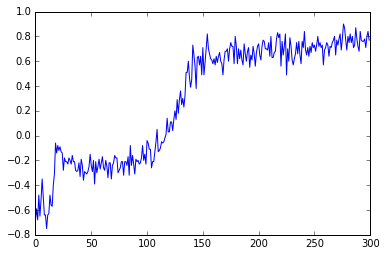

In [11]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [12]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [13]:
sess = tf.InteractiveSession()

In [14]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs3/model-29999.cptk


[2017-06-05 12:02:09,933] Restoring parameters from ./dqn_logs3/model-29999.cptk


In [15]:
#Reset environment and get the first new observation
s = env.reset()
s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 3
Reward: 1 , Done: True
End of training episode


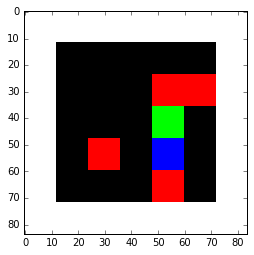

In [76]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print("Action: %d" % a)
s1, r, d = env.step(a)
print("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [41]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [ ]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn_logs3/model-29999.cptk


[2017-06-05 13:57:31,490] Restoring parameters from ./dqn_logs3/model-29999.cptk


72	0.9
196	0.8
319	0.8
456	0.8
488	1.0
566	0.9
656	0.9
734	0.9
858	0.8
891	1.0
923	1.0
1047	0.8
1226	0.7
1352	0.8
1480	0.8
1659	0.7
1781	0.8
1901	0.8
1983	0.9
2158	0.7
2289	0.8
2451	0.7
2545	0.9
2678	0.8
2756	0.9
2838	0.9
3061	0.6
3185	0.8
3313	0.8
3342	1.0
3509	0.7
3579	0.9
3806	0.6
3931	0.8
4108	0.7
4191	0.9
4322	0.8
4445	0.8
4520	0.9
4642	0.8
4855	0.6
4992	0.8
5073	0.9
5300	0.6
5470	0.7
5686	0.6
5805	0.8
5932	0.8
5953	1.0
6121	0.7
6301	0.7
6390	0.9
6471	0.9
6595	0.8
6723	0.8
6814	0.9
6979	0.7
7103	0.8
7173	0.9
7296	0.8
7427	0.8
7498	0.9
7578	0.9
7755	0.7
7918	0.7
8090	0.7
8269	0.7
8440	0.7
8613	0.7
8642	1.0
8768	0.8
8797	1.0
8969	0.7
9051	0.9
9134	0.9
9173	1.0
9291	0.8
9468	0.7
9501	1.0
9628	0.8
9748	0.8
9825	0.9
9965	0.8
10134	0.7
10221	0.9
10299	0.9
10522	0.6
10652	0.8
10777	0.8
10947	0.7
11032	0.9
11213	0.7
11381	0.7
11558	0.7
11644	0.9
11815	0.7
11949	0.8
12032	0.9
12102	0.9
12193	0.9
12359	0.7
12542	0.7
12708	0.7
12881	0.7
13147	0.5
13274	0.8
13311	1.0
13485	0.7
13563	0.9
13736

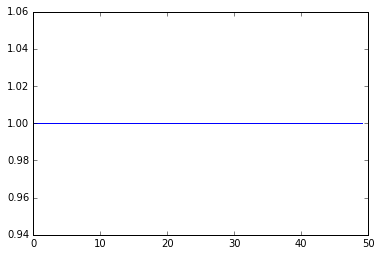

In [43]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [45]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

102	-1.0
133	-1.0
201	-0.4
289	-1.0
340	-1.0
379	-0.8
426	-0.6
509	-0.9
564	-1.0
615	-0.6
669	-1.0
729	-0.8
803	-1.0
900	-1.0
940	-1.0
995	-0.4
1059	-1.0
1181	-0.8
1285	-0.8
1353	-1.0
1462	-0.8
1521	-1.0
1582	-1.0
1639	-0.8
1709	-0.8
1793	-0.6
1851	-0.4
1939	-0.5
1978	-0.8
2035	-0.8
2107	-0.8
2186	-1.0
2300	-0.9
2399	-0.8
2520	-0.8
2609	-1.0
2653	-1.0
2695	-1.0
2774	-0.8
2843	-0.8
2888	-1.0
2921	-0.8
2963	-0.8
2991	-1.0
3040	-0.8
3145	-1.0
3213	-1.0
3278	-1.0
3317	-1.0
3361	-0.8
3455	-0.8
3511	-0.6
3568	-1.0
3636	-0.8
3711	-0.8
3783	-1.0
3841	-1.0
3901	-0.6
3959	-0.8
4019	-0.8
4083	-1.0
4145	-1.0
4242	-0.8
4328	-1.0
4412	-0.8
4459	-0.8
4542	-0.8
4649	-1.0
4710	-0.8
4768	-0.8
4872	-1.0
4922	-0.8
5004	-1.0
5079	-0.6
5170	-0.8
5268	-1.0
5323	-0.8
5391	-0.2
5505	-0.8
5597	-0.8
5649	-1.0
5694	-1.0
5770	-0.8
5829	-0.4
5944	-0.8
5974	-1.0
6020	-1.0
6120	-1.0
6173	-0.8
6253	-0.8
6314	-1.0
6356	-0.6
6423	-0.8
6504	-1.0
6569	-1.0
6623	-0.8
6693	-1.0
6760	-0.8
6818	-1.0
6905	-1.0
6986	-0.8
7065	-

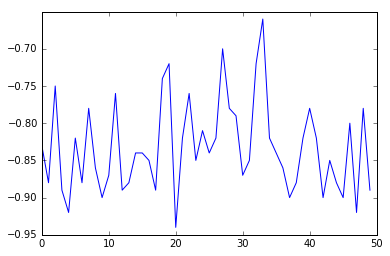

In [46]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)